In [13]:
using Random
using Statistics
using DataFrames
using CSV
using Plots
using JuMP, Gurobi
using GLMNet
using MLBase
using Pkg
using Distributions
using HMMBase
using BenchmarkTools
using Distances
using EvalMetrics
using LinearAlgebra

In [14]:
using Pkg
Pkg.add("EvalMetrics")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [15]:
gurobi_env = Gurobi.Env() ; 

Academic license - for non-commercial use only - expires 2022-09-11


In [16]:
model = Model(with_optimizer(Gurobi.Optimizer, gurobi_env))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi

In [17]:
Random.seed!(15095)

MersenneTwister(15095)

In [18]:
## Define size of problem 
m = 10 ; #Number of states

### Define True HMM parameters and emission distributions

In [19]:
# Define True probabilities matrix
pi_true = rand(Float64, m) ; 
pi_true = (pi_true)./(sum(pi_true)) ;  # So that initial probabilities sum to 1

#Define State transition probabilities

A_true = rand(Float64, (m,m)) ; 
for i =1:m
   A_true[i,:]  = A_true[i,:]/(sum(A_true[i,:])) ;
end

In [20]:
println("True probabilities: ")
pi_true

True probabilities: 


10-element Vector{Float64}:
 0.07486090994046252
 0.06630907995099644
 0.04635497490858906
 0.12989977210234596
 0.07946431674890926
 0.007701590683127249
 0.03216603198044118
 0.22843504422317773
 0.2659854323941368
 0.06882284706781369

In [21]:
println("State transition probabilities: ")
A_true

State transition probabilities: 


10×10 Matrix{Float64}:
 0.0752931   0.1341      0.0197698  …  0.0199917  0.116939   0.131136
 0.0850281   0.00812193  0.110777      0.140611   0.160813   0.102774
 0.118604    0.0305247   0.0441062     0.0406136  0.0577275  0.11217
 0.00860176  0.133947    0.124884      0.13774    0.108742   0.0446017
 0.114674    0.100397    0.0918971     0.131533   0.127359   0.0111749
 0.03043     0.148723    0.100613   …  0.0977629  0.14696    0.0136002
 0.0678053   0.0963498   0.161962      0.0260425  0.137581   0.0375044
 0.184826    0.00294772  0.125397      0.194892   0.0573867  0.0430482
 0.135083    0.00606615  0.176531      0.0378103  0.0582549  0.194518
 0.105152    0.0999984   0.0828344     0.0766694  0.173632   0.148507

In [22]:
k = 2 ;

emission_dists = [Normal(0,1) , Normal(1*k,1) , Normal(2*k,1), Normal(3*k,1), Normal(4*k,1)
                , Normal(5*k,1), Normal(6*k,1), Normal(7*k,1), Normal(8*k,1), Normal(9*k,1) ] ; 

In [23]:
hmm = HMM(pi_true , A_true, emission_dists) ; 

#### Generate multiple sequences

In [24]:
## Generate one sequence of 1000 timesteps
seq_length = 1000 ; 
num_sequences = 20 ; 


S = zeros((num_sequences, seq_length)) ; 
X = zeros((num_sequences, seq_length)) ; 

for i =1:num_sequences
    S[i,:] , X[i,:] = rand(hmm, seq_length, seq = true) ; 
end


### Define EM algorithm initializations and hyperparameters

In [25]:
## Initialize guesses

pi_init = rand(Float64, m) ;  
pi_init = (pi_init)./(sum(pi_init)) ;  # So that initial probabilities sum to 1


#Define State transition probabilities

A_init = rand(Float64, (m,m)) ; 
for i =1:m
   A_init[i,:]  = A_init[i,:]/(sum(A_init[i,:])) ;
end


#Initial guess for robust delta(X)
delta_X_init = zeros(size(X)) ; 

In [26]:
println("Initial probabilities: ")
pi_init

Initial probabilities: 


10-element Vector{Float64}:
 0.09337126311566676
 0.13008960499648123
 0.0903743031576442
 0.0368527173717776
 0.13669754313436053
 0.12923806151185907
 0.11316055276641604
 0.056188388928618625
 0.07585790846187433
 0.1381696565553015

In [27]:
println("State transition probabilities: ")
A_init

State transition probabilities: 


10×10 Matrix{Float64}:
 0.119182   0.0916132  0.145215    …  0.0452275   0.151424    0.120948
 0.192092   0.0640587  0.00398755     0.036053    0.125179    0.0894101
 0.140599   0.0378444  0.203763       0.199694    0.00892771  0.142407
 0.0438746  0.0858752  0.15924        0.0845655   0.0858255   0.131774
 0.110856   0.135899   0.160083       0.0711038   0.0407293   0.150869
 0.115175   0.0554857  0.0432153   …  0.149235    0.089961    0.116349
 0.185008   0.125405   0.0715968      0.151615    0.0904685   0.00362629
 0.106545   0.0842589  0.117221       0.123764    0.121444    0.108599
 0.120168   0.0522632  0.146165       0.00783045  0.106014    0.14683
 0.16063    0.0921704  0.0609777      0.136268    0.024164    0.0335079

In [28]:
## Define hyperparameters for algo

r = 0.05 ; # Radius of uncertainty set to be used
num_iters = 100 ; 

### Define EM algorithm functions

In [29]:
## Start EM algorithm for multiple sequence training

function baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters)

    pi_current = pi_init ; 
    A_current = A_init ; 
    delta_X_current = delta_X_init ; 


    ll_tracker = [] ; 
    ll_last = -1e+8 ;

    for iter=1:num_iters

        if (iter%10==0)
            print("Running iteration number: ") ; 
            println(iter) ; 
        end

        ## E-step - Compute α and β given current pi, A and delta_X

        # For current iteration define HMM with current guesses of pi, A and delta_X 

        # Emission distribution is assumed to be known
        hmm_current = HMM(pi_current , A_current, emission_dists) ; 

        # Using current estimate of worst possible delta_X to get α and β

        alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
        beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]


        # Run forward-backward algorithm on all the sequences
        for seq_num=1:size(X,1)    
            alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
            beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        end


        ## Multiply in sigma and -1 for ease in later computations

        alpha_sigma_current = zeros(size(alpha_current)) ; 
        for i=1:m
             alpha_sigma_current[:,:,i] = -(alpha_current[:,:,i])/(2*(emission_dists[i].σ)^2) ; 
        end


        ##Track log-likelihood - of current parameters guess with the actual data 

        ll_tr = 0 
        for seq_num=1:size(X,1)
            alp_discard, ll_temp = forward(hmm_current, (X[seq_num,:]) ) ;
            ll_tr = ll_tr + ll_temp
        end

        ll_tr = (1/size(X,1))*ll_tr ; 

        append!(ll_tracker, ll_tr) ; 
        print("Current log-likelihood: ") ; 
        println(ll_tr) ; 

#         if ((ll_tr - ll_last) < 1e-3)
#              return pi_current, A_current
#         end
        
        ll_last = ll_tr ; 
        
        ## Define new quantities γ_ij(t) and ξ_ij(t) for each sequence

        gamma_current = zeros((size(X,1), size(X,2) , m)) ; ## Indexed as γ[seq_num,t,i]
        eta_current = zeros((size(X,1) , size(X,2)-1, m, m)) ;  # Indexed as ξ[seq_num,t,i,j]

        # Fill in gamma vals
        gamma_current = alpha_current.*beta_current ; 

        for seq_num=1:size(X,1)
            for t=1:size(X,2)        
                gamma_current[seq_num, t, :] = gamma_current[seq_num, t, :]./(sum(gamma_current[seq_num, t, :])) ;             
            end
        end

        ## FIll in eta vals

        for seq_num=1:size(X,1)
            for i=1:m
                for j=1:m
                    for t=1:size(X,2)-1
                        eta_current[seq_num,t,i,j] = alpha_current[seq_num,t,i]*A_current[i,j]*(pdf( emission_dists[j], (X[seq_num,t+1]+delta_X_current[seq_num,t+1]) ))*beta_current[seq_num, t+1,j]
                    end
                end
            end
        end

        for seq_num=1:size(X,1)
            for t=1:size(X,2)-1
                 eta_current[seq_num,t,:,:] = eta_current[seq_num, t,:,:]/sum(eta_current[seq_num,t,:,:])  ;  
            end
        end

    #     println("Computed necessary vals")
    #     println(size(eta_current))

        ## Update parameter values 

        pi_next = zeros(size(pi_init)) ; 
        A_next = zeros(size(A_init)) ; 

        for seq_num=1:size(X,1)
            pi_next = pi_next + gamma_current[seq_num, 1, :]
        end
        pi_next = pi_next./(size(X,1)) ; 

        for i=1:m
            for j=1:m        
                A_next[i,j] = sum(eta_current[:,:,i,j])/sum(gamma_current[:,1:size(X,2)-1,i]) ;                      
            end
        end


        pi_current = pi_next ; 
        A_current = A_next ; 

    #     println("One loop over")

    end
    return pi_current, A_current, ll_tracker
end

baum_welch (generic function with 1 method)

In [163]:
## Start EM algorithm for multiple sequence training

function robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

    pi_current = pi_init ; 
    A_current = A_init ; 
    delta_X_current = delta_X_init ; 


    ll_tracker = [] ; 
    
    
    ll_last = -1e+8 ; 

    for iter=1:num_iters

        if (iter%10==0)
            print("Running iteration number: ") ; 
            println(iter) ; 
        end

        ## E-step - Compute α and β given current pi, A and delta_X

        # For current iteration define HMM with current guesses of pi, A and delta_X 

        # Emission distribution is assumed to be known
        hmm_current = HMM(pi_current , A_current, emission_dists) ; 

        # Using current estimate of worst possible delta_X to get α and β

        alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
        beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]


        # Run forward-backward algorithm on all the sequences
        for seq_num=1:size(X,1)    
            alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
            beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        end


        ## Multiply in sigma and -1 for ease in later computations

        alpha_sigma_current = zeros(size(alpha_current)) ; 
        for i=1:m
             alpha_sigma_current[:,:,i] = -(alpha_current[:,:,i])/(2*(emission_dists[i].σ)^2) ; 
        end


        ##Track log-likelihood - of current parameters guess with the actual data 

        ll_tr = 0 
        for seq_num=1:size(X,1)
            alp_discard, ll_temp = forward(hmm_current, (X[seq_num,:]) ) ;
            ll_tr = ll_tr + ll_temp
        end

        ll_tr = (1/size(X,1))*ll_tr ; 
    
        
        append!(ll_tracker, ll_tr) ; 
        #print("Current log-likelihood: ") ; 
        #println(ll_tr) ; 
        #print(ll_last) ; 
    
        
#         if ((ll_tr - ll_last) < 1e-3)
#              return pi_current, A_current
#         end


        
        ll_last = ll_tr ; 

        ## M-step 1: Solve inner minimization problem to get best value of delta_X
        ## Do this by solving minimization problem for each sequence one after another - It's the same thing for 
        ## Each sequence and they do no interact in any way!
        for seq_num=1:size(X,1)

            # Build model
            model = Model(with_optimizer(Gurobi.Optimizer, gurobi_env, NonConvex = 2)) ; 
            set_optimizer_attribute(model, "OutputFlag", 0) ;

            # Insert variables

            #delta_x variables
            @variable(model,delta_X[t=1:size(X,2)]) ; # If multivariate change this line
            @variable(model,diff[t=1:size(X,2), i=1:m]) ;  # If multivariate change this line

            #Insert constraints - For 1-D it is the same to use 1-norm or 2-norm will use linear constraints

            @constraint(model,[i=1:size(X,2)], delta_X[i] <= r ) ;
            @constraint(model,[i=1:size(X,2)], delta_X[i] >= -r ) ;
            @constraint(model,[t=1:size(X,2), i=1:m], diff[t,i] == (X[seq_num, t] + delta_X[t] - emission_dists[i].μ )) ;


            #Objective
            @objective(model,Min, sum(alpha_sigma_current[seq_num,:,:].*beta_current[seq_num,:,:].*(diff.^2))) ;

            # Optimize
            optimize!(model)

            delta_X_current[seq_num, :] = value.(delta_X) ;       
        end

        #println("Model optimization done!")



        ## M-step 2: Replace X by X+delta_X_current - Solve for pi_new, A_new

        ## Re-compute α and β based on new delta? Not sure if to do or not - Can try both and 
        #see which gives good results

        alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
        beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]

        # Run forward-backward algorithm on all the sequences
        for seq_num=1:size(X,1)    
            alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
            beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        end


        ## Define new quantities γ_ij(t) and ξ_ij(t) for each sequence

        gamma_current = zeros((size(X,1), size(X,2) , m)) ; ## Indexed as γ[seq_num,t,i]
        eta_current = zeros((size(X,1) , size(X,2)-1, m, m)) ;  # Indexed as ξ[seq_num,t,i,j]

        # Fill in gamma vals
        gamma_current = alpha_current.*beta_current ; 

        for seq_num=1:size(X,1)
            for t=1:size(X,2)        
                gamma_current[seq_num, t, :] = gamma_current[seq_num, t, :]./(sum(gamma_current[seq_num, t, :])) ;             
            end
        end

        ## FIll in eta vals

        for seq_num=1:size(X,1)
            for i=1:m
                for j=1:m
                    for t=1:size(X,2)-1
                        eta_current[seq_num,t,i,j] = alpha_current[seq_num,t,i]*A_current[i,j]*(pdf( emission_dists[j], (X[seq_num,t+1]+delta_X_current[seq_num,t+1]) ))*beta_current[seq_num, t+1,j]
                    end
                end
            end
        end

        for seq_num=1:size(X,1)
            for t=1:size(X,2)-1
                 eta_current[seq_num,t,:,:] = eta_current[seq_num, t,:,:]/sum(eta_current[seq_num,t,:,:])  ;  
            end
        end

    #     println("Computed necessary vals")
    #     println(size(eta_current))

        ## Update parameter values 

        pi_next = zeros(size(pi_init)) ; 
        A_next = zeros(size(A_init)) ; 

        for seq_num=1:size(X,1)
            pi_next = pi_next + gamma_current[seq_num, 1, :]
        end
        pi_next = pi_next./(size(X,1)) ; 

        for i=1:m
            for j=1:m        
                A_next[i,j] = sum(eta_current[:,:,i,j])/sum(gamma_current[:,1:size(X,2)-1,i]) ;                      
            end
        end


        pi_current = pi_next ; 
        A_current = A_next ; 

    #     println("One loop over")

    end
    return pi_current, A_current, ll_tracker
end



robust_baum_welch (generic function with 1 method)

In [208]:
## Start EM algorithm for multiple sequence training

function optimistic_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

    pi_current = pi_init ; 
    A_current = A_init ; 
    delta_X_current = delta_X_init ; 


    ll_tracker = [] ; 
    
    
    ll_last = -1e+8 ; 

    for iter=1:num_iters

        if (iter%10==0)
            print("Running iteration number: ") ; 
            println(iter) ; 
        end

        ## E-step - Compute α and β given current pi, A and delta_X

        # For current iteration define HMM with current guesses of pi, A and delta_X 

        # Emission distribution is assumed to be known
        hmm_current = HMM(pi_current , A_current, emission_dists) ; 

        # Using current estimate of worst possible delta_X to get α and β

        alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
        beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]


        # Run forward-backward algorithm on all the sequences
        for seq_num=1:size(X,1)    
            alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
            beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        end


        ## Multiply in sigma and -1 for ease in later computations

        alpha_sigma_current = zeros(size(alpha_current)) ; 
        for i=1:m
             alpha_sigma_current[:,:,i] = -(alpha_current[:,:,i])/(2*(emission_dists[i].σ)^2) ; 
        end


        ##Track log-likelihood - of current parameters guess with the actual data 

        ll_tr = 0 
        for seq_num=1:size(X,1)
            alp_discard, ll_temp = forward(hmm_current, (X[seq_num,:]) ) ;
            ll_tr = ll_tr + ll_temp
        end

        ll_tr = (1/size(X,1))*ll_tr ; 
    
        
        append!(ll_tracker, ll_tr) ; 
#         print("Current log-likelihood: ") ; 
#         println(ll_tr) ; 
        #print(ll_last) ; 
    
        
#         if ((ll_tr - ll_last) < 1e-3)
#              return pi_current, A_current
#         end


        
        ll_last = ll_tr ; 

        ## M-step 1: Solve inner minimization problem to get best value of delta_X
        ## Do this by solving minimization problem for each sequence one after another - It's the same thing for 
        ## Each sequence and they do no interact in any way!
        for seq_num=1:size(X,1)

            # Build model
            model = Model(with_optimizer(Gurobi.Optimizer, gurobi_env)) ; 
            set_optimizer_attribute(model, "OutputFlag", 0) ;

            # Insert variables

            #delta_x variables
            @variable(model,delta_X[t=1:size(X,2)]) ; # If multivariate change this line
            @variable(model,diff[t=1:size(X,2), i=1:m]) ;  # If multivariate change this line

            #Insert constraints - For 1-D it is the same to use 1-norm or 2-norm will use linear constraints

            @constraint(model,[i=1:size(X,2)], delta_X[i] <= r ) ;
            @constraint(model,[i=1:size(X,2)], delta_X[i] >= -r ) ;
            @constraint(model,[t=1:size(X,2), i=1:m], diff[t,i] == (X[seq_num, t] + delta_X[t] - emission_dists[i].μ )) ;


            #Objective
            @objective(model,Max, sum(alpha_sigma_current[seq_num,:,:].*beta_current[seq_num,:,:].*(diff.^2))) ;

            # Optimize
            optimize!(model)

            delta_X_current[seq_num, :] = value.(delta_X) ;       
        end

        #println("Model optimization done!")



        ## M-step 2: Replace X by X+delta_X_current - Solve for pi_new, A_new

        ## Re-compute α and β based on new delta? Not sure if to do or not - Can try both and 
        #see which gives good results

        alpha_current = zeros((size(X,1) , size(X,2), m)) ;  #alpha indexed as alpha[seq_num,t,i]
        beta_current = zeros((size(X,1) , size(X,2), m)) ;  #beta[seq_num,t,i]

        # Run forward-backward algorithm on all the sequences
        for seq_num=1:size(X,1)    
            alpha_current[seq_num,:,:], ll = forward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
            beta_current[seq_num,:,:], ll = backward(hmm_current, (X[seq_num,:]+delta_X_current[seq_num,:])) ;
        end


        ## Define new quantities γ_ij(t) and ξ_ij(t) for each sequence

        gamma_current = zeros((size(X,1), size(X,2) , m)) ; ## Indexed as γ[seq_num,t,i]
        eta_current = zeros((size(X,1) , size(X,2)-1, m, m)) ;  # Indexed as ξ[seq_num,t,i,j]

        # Fill in gamma vals
        gamma_current = alpha_current.*beta_current ; 

        for seq_num=1:size(X,1)
            for t=1:size(X,2)        
                gamma_current[seq_num, t, :] = gamma_current[seq_num, t, :]./(sum(gamma_current[seq_num, t, :])) ;             
            end
        end

        ## FIll in eta vals

        for seq_num=1:size(X,1)
            for i=1:m
                for j=1:m
                    for t=1:size(X,2)-1
                        eta_current[seq_num,t,i,j] = alpha_current[seq_num,t,i]*A_current[i,j]*(pdf( emission_dists[j], (X[seq_num,t+1]+delta_X_current[seq_num,t+1]) ))*beta_current[seq_num, t+1,j]
                    end
                end
            end
        end

        for seq_num=1:size(X,1)
            for t=1:size(X,2)-1
                 eta_current[seq_num,t,:,:] = eta_current[seq_num, t,:,:]/sum(eta_current[seq_num,t,:,:])  ;  
            end
        end

    #     println("Computed necessary vals")
    #     println(size(eta_current))

        ## Update parameter values 

        pi_next = zeros(size(pi_init)) ; 
        A_next = zeros(size(A_init)) ; 

        for seq_num=1:size(X,1)
            pi_next = pi_next + gamma_current[seq_num, 1, :]
        end
        pi_next = pi_next./(size(X,1)) ; 

        for i=1:m
            for j=1:m        
                A_next[i,j] = sum(eta_current[:,:,i,j])/sum(gamma_current[:,1:size(X,2)-1,i]) ;                      
            end
        end


        pi_current = pi_next ; 
        A_current = A_next ; 

    #     println("One loop over")

    end
    return pi_current, A_current, ll_tracker
end




optimistic_baum_welch (generic function with 1 method)

In [33]:
num_iters = 40

40

In [45]:
Pr,Ar,Lr = robust_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -3119.846310717446
Current log-likelihood: -3043.3314971862455
Current log-likelihood: -3025.0196638652615
Current log-likelihood: -3016.5316267114526
Current log-likelihood: -3011.9098513592953
Current log-likelihood: -3009.1290409987164
Current log-likelihood: -3007.3017245468673
Current log-likelihood: -3006.0266230853003
Current log-likelihood: -3005.0815573690506
Running iteration number: 10
Current log-likelihood: -3004.376257969454
Current log-likelihood: -3003.818543147768
Current log-likelihood: -3003.380147009155
Current log-likelihood: -3003.0298696746904
Current log-likelihood: -3002.748430705276
Current log-likelihood: -3002.518165037167
Current log-likelihood: -3002.331453969042
Current log-likelihood: -3002.175789068484
Current log-likelihood: -3002.0478157174216
Current log-likelihood: -3001.9395792967134
Running iteration number: 20
Current log-likelihood: -3001.849907739719
Current log-likelihood: -3001.7728359445555
Current log-likelihood: -30

([0.04999926679916111, 1.638469724915356e-6, 4.149325203445562e-7, 0.13163449017264878, 0.0974023009864676, 0.06817860224822266, 0.017047836274403073, 0.1824371890449663, 0.31681750153453236, 0.13648075953735286], [0.07924420129100972 0.12405305958230471 … 0.11197431683084959 0.11055682481982165; 0.07554368413800505 0.03773410407278053 … 0.17932643427374376 0.09160622481802054; … ; 0.14232834957099583 0.010064460574151293 … 0.06962234954508903 0.1861526097799557; 0.11383566714179431 0.11567120183719239 … 0.14267012356907194 0.14716774330895901], Any[-3119.846310717446, -3043.3314971862455, -3025.0196638652615, -3016.5316267114526, -3011.9098513592953, -3009.1290409987164, -3007.3017245468673, -3006.0266230853003, -3005.0815573690506, -3004.376257969454  …  -3002.331453969042, -3002.175789068484, -3002.0478157174216, -3001.9395792967134, -3001.849907739719, -3001.7728359445555, -3001.708456885841, -3001.651657194934, -3001.605054400899, -3001.562948143986])

In [46]:
P,A,L = baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters)

Current log-likelihood: -3119.846310717446
Current log-likelihood: -3047.894016980942
Current log-likelihood: -3029.25027010739
Current log-likelihood: -3020.324945560498
Current log-likelihood: -3015.160878736591
Current log-likelihood: -3011.882997815117
Current log-likelihood: -3009.6588408221232
Current log-likelihood: -3008.065868850079
Current log-likelihood: -3006.8743527316974
Running iteration number: 10
Current log-likelihood: -3005.9520269675154
Current log-likelihood: -3005.2187617283316
Current log-likelihood: -3004.623895794936
Current log-likelihood: -3004.134118142398
Current log-likelihood: -3003.7265822860045
Current log-likelihood: -3003.384885109477
Current log-likelihood: -3003.0967261835995
Current log-likelihood: -3002.8525571407245
Current log-likelihood: -3002.6447909444246
Current log-likelihood: -3002.467313329636
Running iteration number: 20
Current log-likelihood: -3002.315155035734
Current log-likelihood: -3002.1842538731266
Current log-likelihood: -3002.0

([0.04999568205446603, 5.286763677615778e-6, 5.360940410866922e-7, 0.13305117573763853, 0.09602068838515536, 0.0669978338047627, 0.02097302831809614, 0.17812519281428124, 0.31889572770933056, 0.1359348483185508], [0.07999749828001716 0.12218553443337389 … 0.11075978758026889 0.11063944276004924; 0.07392344615715823 0.041387711275657144 … 0.18276442502275636 0.09164884762105018; … ; 0.14332905543699068 0.01051383121211251 … 0.07099195319506556 0.18557077434923727; 0.113233334691821 0.11604489026739885 … 0.14195992133856497 0.1474178744668163], Any[-3119.846310717446, -3047.894016980942, -3029.25027010739, -3020.324945560498, -3015.160878736591, -3011.882997815117, -3009.6588408221232, -3008.065868850079, -3006.8743527316974, -3005.9520269675154  …  -3003.0967261835995, -3002.8525571407245, -3002.6447909444246, -3002.467313329636, -3002.315155035734, -3002.1842538731266, -3002.0712727861487, -3001.973457269165, -3001.888522719645, -3001.814565308771])

In [47]:
Po,Ao,Lo = optimistic_baum_welch(X, pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -3119.846310717446
Current log-likelihood: -3048.536195394002
Current log-likelihood: -3029.4149217472714
Current log-likelihood: -3020.051303970967
Current log-likelihood: -3014.522335898313
Current log-likelihood: -3010.918399674008
Current log-likelihood: -3008.44131758833
Current log-likelihood: -3006.6732154123747
Current log-likelihood: -3005.371496093181
Running iteration number: 10
Current log-likelihood: -3004.3934167182615
Current log-likelihood: -3003.6475495874042
Current log-likelihood: -3003.0727021066004
Current log-likelihood: -3002.627431644043
Current log-likelihood: -3002.2805359241534
Current log-likelihood: -3002.011750265858
Current log-likelihood: -3001.804883890498
Current log-likelihood: -3001.6459663011988
Current log-likelihood: -3001.524572911736
Current log-likelihood: -3001.432212243448
Running iteration number: 20
Current log-likelihood: -3001.3615659647003
Current log-likelihood: -3001.3070841624312
Current log-likelihood: -3001.2

([0.05000034812586559, 5.81007040338891e-8, 1.3125983261493437e-10, 0.15533826592949765, 0.07214781758980288, 0.07308367266561888, 0.0011789360424729251, 0.17820890863501918, 0.3402449772105788, 0.12979701556918033], [0.07071251355629296 0.1440277046509251 … 0.1195081280033512 0.10922514214934044; 0.07915598796593278 0.0296665173330697 … 0.20589755047607586 0.07784980948879335; … ; 0.1416347071165104 0.0025983971483578895 … 0.06294684562227956 0.1996155705111687; 0.10850290386265489 0.12756822903906695 … 0.1557850160158796 0.1418984028238894], Any[-3119.846310717446, -3048.536195394002, -3029.4149217472714, -3020.051303970967, -3014.522335898313, -3010.918399674008, -3008.44131758833, -3006.6732154123747, -3005.371496093181, -3004.3934167182615  …  -3001.804883890498, -3001.6459663011988, -3001.524572911736, -3001.432212243448, -3001.3615659647003, -3001.3070841624312, -3001.264209243957, -3001.2300269257707, -3001.2022754823383, -3001.1792665017924])

In [34]:
## Get KL divergence between pi_true and pi_est
## Get KL divergence between each row of A_true with corresponding row of A_est
## Get average KL divergence across all rows of A_true with A_est

# D(true||estimate)

function eval_param_ests(A_true, pi_true, A_est, pi_est)
    pi_kl1 = kldivergence(pi_true , pi_est) ; 
    pi_kl2 = kldivergence(pi_est, pi_true) ; 
    
    A_kl1 = zeros(size(A_true, 1)) ; 
    A_kl2 = zeros(size(A_true, 1)) ; 
    
    for i=1:size(A_true, 1)
        A_kl1[i] = kldivergence(A_true[i,:], A_est[i,:])
        A_kl2[i] = kldivergence(A_est[i,:], A_true[i,:])
    end
    
    return pi_kl1, pi_kl2, sum(A_kl1)/size(A_true,1), sum(A_kl2)/size(A_true,1)
    
    
end




eval_param_ests (generic function with 1 method)

In [35]:
function conf_matrix(target_vec, pred_vec, m)
    conf_mat = zeros((m,m))
    for i=1:size(target_vec,1)
         conf_mat[Int(target_vec[i]), Int(pred_vec[i])] = conf_mat[Int(target_vec[i]), Int(pred_vec[i])] + 1 ;
    end
    return conf_mat
end

conf_matrix (generic function with 1 method)

In [36]:
## Write function to --> 
#Inputs - X, S_true, pi, A 
# Estimate S given pi, A --> 
# Output confusion matrix based on true states and guessed states
## Output Estimated state matrix and confusion matrix

function eval_state_ests(X, S_true, pi, A, emission_dists)
    hmm_est = HMM(pi , A, emission_dists)
    S_est = zeros(size(S_true)) ; 
    conf_mat = zeros(size(A)) ; 
    
    for i=1:size(X,1)
        S_est[i,:] = viterbi(hmm_est, X[i,:]) ;
        conf_mat = conf_mat + conf_matrix(S_true[i,:] , S_est[i,:] , size(A,1))
    end
    
    return S_est, conf_mat

end



eval_state_ests (generic function with 1 method)

1. We have
    1. Evaluate parameter estimates against true parameters
    2. Decode HMM using all sets of parameters - and get accuracy of decoded states with respect to the true states
    
2. Data we have
    1. Train data - 10 sequences 
        1. S_true, X_orig = Generated using pi_true and A_true
        2. X_orig + Noise (zero mean variance = [0,0.01, 0.1, 1])
    2. Test data - 1 sequence
        1. X_orig_test = Generated using pi_true and A_true
        2. X_orig + Noise (zero mean variance = [0,0.01, 0.1, 1])
        
3. Experiments to do - For each train data set of sequences
    1. Do parameter estimation using
        1. Regular EM
        2. Robust EM with varying r
        3. Optimistic EM with varying r
        
    2. Evaluation:
        1. Compare estimated paramaters wrt true parameters
        2. Decode train sequence - with true parameters
        3. Decode train sequence with all the estimated parameters
            1. Compare each with true sequence
        4. Decode test sequence - with true parameters
        5. Decode test sequence with all the estimated parameters
            1. Compare each with test sequence



## Some preliminary tests

In [99]:
A_T = [0.29778560911054225 0.13544487012366083 0.3604481008164021 0.13238372924911454 0.07393769070028032; 0.056989124095932445 0.09324406686115916 0.40251043012728044 0.11816783668377405 0.3290885422318539; 0.13927226693759806 0.27970224273576827 0.19746392245773273 0.1845472458602735 0.19901432200862743; 0.21693169962458078 0.2182901076722709 0.1921400612288617 0.24465165790282975 0.1279864735714569; 0.18454532108327124 0.05632159948828856 0.26480731721188605 0.23413707374892295 0.2601886884676312]
pi_T = [0.20787184793908514, 0.23893628208513792, 0.26064943402664353, 0.022544860169927333, 0.2699975757792061] ; 

### Noise = 0.1

In [95]:
## Read in some data
X_no = Matrix(DataFrame(CSV.read("Saved_Params/r-0.0_noise-0.1_X.csv", DataFrame))) ; 

A_em = Matrix(DataFrame(CSV.read("Saved_Params/r-0.0_noise-0.1_A.csv", DataFrame))) ; 
pi_em = Matrix(DataFrame(CSV.read("Saved_Params/r-0.0_noise-0.1_pi.csv", DataFrame)))[:,1] ; 


A_rob1 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.01_noise-0.1_A.csv", DataFrame))) ; 
pi_rob1 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.01_noise-0.1_pi.csv", DataFrame)))[:,1] ; 


A_rob2 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.1_noise-0.1_A.csv", DataFrame))) ; 
pi_rob2 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.1_noise-0.1_pi.csv", DataFrame)))[:,1] ; 

A_rob3 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.5_noise-0.1_A.csv", DataFrame))) ; 
pi_rob3 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.5_noise-0.1_pi.csv", DataFrame)))[:,1] ; 

#### Optimitic #######

A_opt1 = Matrix(DataFrame(CSV.read("Optimistic/r-0.01_noise-0.1_A.csv", DataFrame))) ; 
pi_opt1 = Matrix(DataFrame(CSV.read("Optimistic/r-0.01_noise-0.1_pi.csv", DataFrame)))[:,1] ; 

A_opt2 = Matrix(DataFrame(CSV.read("Optimistic/r-0.1_noise-0.1_A.csv", DataFrame))) ; 
pi_opt2 = Matrix(DataFrame(CSV.read("Optimistic/r-0.1_noise-0.1_pi.csv", DataFrame)))[:,1] ; 

A_opt3 = Matrix(DataFrame(CSV.read("Optimistic/r-0.5_noise-0.1_A.csv", DataFrame))) ; 
pi_opt3 = Matrix(DataFrame(CSV.read("Optimistic/r-0.5_noise-0.1_pi.csv", DataFrame)))[:,1] ; 






In [100]:
println("kl(pi_true||pi_est) , kl(pi_est||pi_true) , mean(kl(A_true[r]||A_est[r])) , mean(kl(A_est[r]||A_true[r]))")

println("Regular EM")
println(eval_param_ests(A_T, pi_T, A_em, pi_em)) ; 

println("Robust EM, r=0.01")
println(eval_param_ests(A_T, pi_T, A_rob1, pi_rob1)) ; 

println("Robust EM, r=0.1")
println(eval_param_ests(A_T, pi_T, A_rob2, pi_rob2)) ; 

println("Robust EM, r=0.5")
println(eval_param_ests(A_T, pi_T, A_rob3, pi_rob3)) ; 


println("Optimistic EM, r=0.01")
println(eval_param_ests(A_T, pi_T, A_opt1, pi_opt1)) ; 
println("Optimistic EM, r=0.1")
println(eval_param_ests(A_T, pi_T, A_opt2, pi_opt2)) ; 
println("Optimistic EM, r=0.5")
println(eval_param_ests(A_T, pi_T, A_opt3, pi_opt3)) ; 


kl(pi_true||pi_est) , kl(pi_est||pi_true) , mean(kl(A_true[r]||A_est[r])) , mean(kl(A_est[r]||A_true[r]))
Regular EM
(5.248430558516643, 0.5822538512665225, 0.015141032754393388, 0.01511053453507279)
Robust EM, r=0.01
(2.9570333914737774, 0.5651818326443931, 0.012450430298211147, 0.012568038257414215)
Robust EM, r=0.1
(1.9788317340361168, 0.5676172007577037, 0.012758425144230173, 0.01329178164587209)
Robust EM, r=0.5
(0.1605903982100942, 0.14818417872220918, 0.020720844893010737, 0.021705775092624176)
Optimistic EM, r=0.01
(5.35685835657805, 0.5871680727324844, 0.014687989404237883, 0.014674302668690308)
Optimistic EM, r=0.1
(1.508149698351731, 0.5376516037304485, 0.012689297647659682, 0.013298266673163186)
Optimistic EM, r=0.5
(0.17666814281593385, 0.168000051495044, 0.02451128515187821, 0.025160254889958607)


In [102]:
S = Matrix(DataFrame(CSV.read("Saved_Params/true_s.csv", DataFrame))) ; 

In [103]:
S_best, conf_mat_best = eval_state_ests(X_noisy, S, pi_true, A_true, emission_dists[1:5]) ; 

S_em, conf_mat_em = eval_state_ests(X_noisy, S, pi_em, A_em, emission_dists[1:5]) ; 

S_rob1, conf_mat_rob1 = eval_state_ests(X_noisy, S, pi_rob1, A_rob1, emission_dists[1:5]) ; 
S_rob2, conf_mat_rob2 = eval_state_ests(X_noisy, S, pi_rob1, A_rob2, emission_dists[1:5]) ; 
S_rob3, conf_mat_rob3 = eval_state_ests(X_noisy, S, pi_rob1, A_rob3, emission_dists[1:5]) ; 

S_opt1, conf_mat_opt1 = eval_state_ests(X_noisy, S, pi_opt1, A_opt1, emission_dists[1:5]) ; 
S_opt2, conf_mat_opt2 = eval_state_ests(X_noisy, S, pi_opt1, A_opt2, emission_dists[1:5]) ; 
S_opt3, conf_mat_opt3 = eval_state_ests(X_noisy, S, pi_opt1, A_opt3, emission_dists[1:5]) ; 


In [105]:
println("State decoding accuracy: True parameters")
println(tr(conf_mat_best)/sum(conf_mat_best)) ; 

println("State decoding accuracy: EM parameters")
println(tr(conf_mat_em)/sum(conf_mat_em)) ; 

println("State decoding accuracy: Robust EM parameters: r=0.01")
println(tr(conf_mat_rob1)/sum(conf_mat_rob1)) ; 

println("State decoding accuracy: Robust EM parameters: r=0.1")
println(tr(conf_mat_rob2)/sum(conf_mat_rob2)) ;

println("State decoding accuracy: Robust EM parameters: r=0.5")
println(tr(conf_mat_rob3)/sum(conf_mat_rob3)) ;






println("State decoding accuracy: Optimistic EM parameters: r=0.01")
println(tr(conf_mat_opt1)/sum(conf_mat_opt1)) ;

println("State decoding accuracy: Optimistic EM parameters: r=0.1")
println(tr(conf_mat_opt2)/sum(conf_mat_opt2)) ;

println("State decoding accuracy: Optimistic EM parameters: r=0.5")
println(tr(conf_mat_opt3)/sum(conf_mat_opt3)) ;




State decoding accuracy: True parameters
0.7754
State decoding accuracy: EM parameters
0.7654
State decoding accuracy: Robust EM parameters: r=0.01
0.7656
State decoding accuracy: Robust EM parameters: r=0.1
0.7698
State decoding accuracy: Robust EM parameters: r=0.5
0.7716
State decoding accuracy: Optimistic EM parameters: r=0.01
0.7664
State decoding accuracy: Optimistic EM parameters: r=0.1
0.7702
State decoding accuracy: Optimistic EM parameters: r=0.5
0.7736


## Noise = 0.7

In [107]:
## Read in some data
X_noisy = Matrix(DataFrame(CSV.read("Saved_Params/r-0.0_noise-0.7_X.csv", DataFrame))) ; 

A_em = Matrix(DataFrame(CSV.read("Saved_Params/r-0.0_noise-0.7_A.csv", DataFrame))) ; 
pi_em = Matrix(DataFrame(CSV.read("Saved_Params/r-0.0_noise-0.7_pi.csv", DataFrame)))[:,1] ; 

A_rob1 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.01_noise-0.7_A.csv", DataFrame))) ; 
pi_rob1 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.01_noise-0.7_pi.csv", DataFrame)))[:,1] ; 

# A_rob2 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.05_noise-0.1_A.csv", DataFrame))) ; 
# pi_rob2 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.05_noise-0.1_pi.csv", DataFrame))) ; 

A_rob2 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.1_noise-0.7_A.csv", DataFrame))) ; 
pi_rob2 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.1_noise-0.7_pi.csv", DataFrame)))[:,1] ; 

A_rob3 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.5_noise-0.7_A.csv", DataFrame))) ; 
pi_rob3 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.5_noise-0.7_pi.csv", DataFrame)))[:,1] ; 


#### Optimitic #######

# A_opt1 = Matrix(DataFrame(CSV.read("Optimistic/r-0.01_noise-0.7_A.csv", DataFrame))) ; 
# pi_opt1 = Matrix(DataFrame(CSV.read("Optimistic/r-0.01_noise-0.7_pi.csv", DataFrame)))[:,1] ; 

# A_opt2 = Matrix(DataFrame(CSV.read("Optimistic/r-0.1_noise-0.7_A.csv", DataFrame))) ; 
# pi_opt2 = Matrix(DataFrame(CSV.read("Optimistic/r-0.1_noise-0.7_pi.csv", DataFrame)))[:,1] ; 

# A_opt3 = Matrix(DataFrame(CSV.read("Optimistic/r-0.5_noise-0.7_A.csv", DataFrame))) ; 
# pi_opt3 = Matrix(DataFrame(CSV.read("Optimistic/r-0.5_noise-0.7_pi.csv", DataFrame)))[:,1] ; 

In [108]:
println(eval_param_ests(A_true, pi_true, A_em, pi_em)) ; 
println(eval_param_ests(A_true, pi_true, A_rob1, pi_rob1)) ; 
println(eval_param_ests(A_true, pi_true, A_rob2, pi_rob2)) ; 
println(eval_param_ests(A_true, pi_true, A_rob3, pi_rob3)) ; 

(5.423886309162033, 0.5919909946242267, 0.015600450758373952, 0.015475872467457191)
(5.559623317582888, 0.5831380010542034, 0.014329824729135448, 0.014369921399612831)
(2.2625889560819163, 0.5671114254546932, 0.013023400559441723, 0.01373907429779827)
(0.1808608921462077, 0.17200390792376674, 0.022539224086353834, 0.023463808153433154)


In [109]:
S = Matrix(DataFrame(CSV.read("Saved_Params/true_s.csv", DataFrame))) ; 

In [110]:
S_best, conf_mat_best = eval_state_ests(X_noisy, S, pi_true, A_true, emission_dists[1:5]) ; 
S_em, conf_mat_em = eval_state_ests(X_noisy, S, pi_em, A_em, emission_dists[1:5]) ; 
S_rob1, conf_mat_rob1 = eval_state_ests(X_noisy, S, pi_rob1, A_rob1, emission_dists[1:5]) ; 
S_rob2, conf_mat_rob2 = eval_state_ests(X_noisy, S, pi_rob1, A_rob2, emission_dists[1:5]) ; 
S_rob3, conf_mat_rob3 = eval_state_ests(X_noisy, S, pi_rob1, A_rob3, emission_dists[1:5]) ; 

In [111]:
println(tr(conf_mat_best)/sum(conf_mat_best)) ; 
println(tr(conf_mat_em)/sum(conf_mat_em)) ; 
println(tr(conf_mat_rob1)/sum(conf_mat_rob1)) ; 
println(tr(conf_mat_rob2)/sum(conf_mat_rob2)) ;
println(tr(conf_mat_rob3)/sum(conf_mat_rob3)) ;

0.7748
0.7644
0.765
0.771
0.774


### Generate data for a particular noise

In [113]:
## Define size of problem 
m = 5 ; #Number of states

In [114]:
# Define True probabilities matrix
pi_true = rand(Float64, m) ; 
pi_true = (pi_true)./(sum(pi_true)) ;  # So that initial probabilities sum to 1

#Define State transition probabilities

A_true = rand(Float64, (m,m)) ; 
for i =1:m
   A_true[i,:]  = A_true[i,:]/(sum(A_true[i,:])) ;
end

In [115]:
hmm = HMM(pi_true , A_true, emission_dists[1:m]) ; 

In [117]:
## Generate one sequence of 1000 timesteps
seq_length = 500 ; 
num_sequences = 10 ; 


S = zeros((num_sequences, seq_length)) ; 
X = zeros((num_sequences, seq_length)) ; 

for i =1:num_sequences
    S[i,:] , X[i,:] = rand(hmm, seq_length, seq = true) ; 
end



In [118]:
## Initialize guesses

pi_init = rand(Float64, m) ;  
pi_init = (pi_init)./(sum(pi_init)) ;  # So that initial probabilities sum to 1


#Define State transition probabilities

A_init = rand(Float64, (m,m)) ; 
for i =1:m
   A_init[i,:]  = A_init[i,:]/(sum(A_init[i,:])) ;
end


#Initial guess for robust delta(X)
delta_X_init = zeros(size(X)) ; 

In [119]:
X_true = X ; 
S_true = S ; 

## Number of noisy data matrices to make 

n_noisy = 10 ; 
vars = [0.1*(k) for k=1:10] ;  ## Set of variances to be used to generate data

## Define X_noisy

X_noisy = zeros((n_noisy , size(X,1) , size(X,2))) ; 

for i=1:n_noisy
     X_noisy[i,:,:] = X_true + rand(Normal(0,vars[i]) , size(X)) ; 
end

In [121]:
num_iters = 100 ; 

In [122]:
## Run robust for al Rs

rs = [0 , 0.01 , 0.02 , 0.05 , 0.1 , 0.5] ; 

In [130]:
emission_dists = emission_dists[1:m]

5-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.0, σ=1.0)
 Normal{Float64}(μ=2.0, σ=1.0)
 Normal{Float64}(μ=4.0, σ=1.0)
 Normal{Float64}(μ=6.0, σ=1.0)
 Normal{Float64}(μ=8.0, σ=1.0)

In [131]:
r = rs[1]
P1,A1,L1 = robust_baum_welch(X_noisy[1,:,:], pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -1262.0228788073364
Current log-likelihood: -1213.7971980959446
Current log-likelihood: -1204.787773298469
Current log-likelihood: -1201.2002256518351
Current log-likelihood: -1199.191138081634
Current log-likelihood: -1197.987781274697
Current log-likelihood: -1197.2506362466802
Current log-likelihood: -1196.7914178872236
Current log-likelihood: -1196.5003482879063
Running iteration number: 10
Current log-likelihood: -1196.312052802312
Current log-likelihood: -1196.187030781945
Current log-likelihood: -1196.1011634047961
Current log-likelihood: -1196.0396145369807
Current log-likelihood: -1195.993210355323
Current log-likelihood: -1195.9562574011804
Current log-likelihood: -1195.9252145543053
Current log-likelihood: -1195.8978798504706
Current log-likelihood: -1195.8728904436302
Current log-likelihood: -1195.8494137719574
Running iteration number: 20
Current log-likelihood: -1195.8269555765808
Current log-likelihood: -1195.8052393024311
Current log-likelihood: 

([0.3874984615246423, 0.15539161505559101, 0.15405882866428194, 0.11319365884193451, 0.18985743591355012], [0.27771178363001353 0.1430466838015737 … 0.136577928667776 0.027534568139484468; 0.04814323313773499 0.29952957472782776 … 0.09293111016588014 0.2466667879983022; … ; 0.24139080695529594 0.08624756191693336 … 0.39623064963266164 0.25628198829741555; 0.22845765711128976 0.08263586731967593 … 0.28449580632712407 0.26832477910011815], Any[-1262.0228788073364, -1213.7971980959446, -1204.787773298469, -1201.2002256518351, -1199.191138081634, -1197.987781274697, -1197.2506362466802, -1196.7914178872236, -1196.5003482879063, -1196.312052802312  …  -1195.624335959187, -1195.610798511087, -1195.5981865740048, -1195.5864833076532, -1195.5756613090248, -1195.5656847783846, -1195.556511681453, -1195.5480957682173, -1195.5403883596439, -1195.5333398566295])

In [132]:
r = rs[2]
P2,A2,L2 = robust_baum_welch(X_noisy[1,:,:], pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -1262.0228788073364
Current log-likelihood: -1213.6176666316512
Current log-likelihood: -1204.6719062569955
Current log-likelihood: -1201.1248092991661
Current log-likelihood: -1199.147193126363
Current log-likelihood: -1197.9672652993959
Current log-likelihood: -1197.2488109598548
Current log-likelihood: -1196.8029506290493
Current log-likelihood: -1196.5209334928395
Running iteration number: 10
Current log-likelihood: -1196.338628239522
Current log-likelihood: -1196.2173643993233
Current log-likelihood: -1196.133147617658
Current log-likelihood: -1196.0716962672252
Current log-likelihood: -1196.0246348297258
Current log-likelihood: -1195.986234853625
Current log-likelihood: -1195.9533929769595
Current log-likelihood: -1195.9241661348112
Current log-likelihood: -1195.8972861969758
Current log-likelihood: -1195.8719730823648
Running iteration number: 20
Current log-likelihood: -1195.8479215321381
Current log-likelihood: -1195.8247903632719
Current log-likelihood

([0.3876561349404759, 0.15020292379098205, 0.16546448546494474, 0.10589441208556208, 0.19078204371803523], [0.2755981757497423 0.14810093561163337 … 0.13742381304405613 0.02824391311991814; 0.05321506584094624 0.2931895644684675 … 0.09820159690223484 0.24469307648787225; … ; 0.24026937843385623 0.08612293401745398 … 0.3909301579305598 0.2594098732949721; 0.2278039417516746 0.08397671892094362 … 0.2824998277374918 0.26952069664831596], Any[-1262.0228788073364, -1213.6176666316512, -1204.6719062569955, -1201.1248092991661, -1199.147193126363, -1197.9672652993959, -1197.2488109598548, -1196.8029506290493, -1196.5209334928395, -1196.338628239522  …  -1195.644136241763, -1195.6314563481753, -1195.6197106941015, -1195.6088385641676, -1195.5988131564613, -1195.5895883051305, -1195.5810922109256, -1195.5733052100688, -1195.566154368118, -1195.5595702827086])

In [133]:
r = rs[3]
P3,A3,L3 = robust_baum_welch(X_noisy[2,:,:], pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -1264.5048179600192
Current log-likelihood: -1215.336589269575
Current log-likelihood: -1206.8741979922859
Current log-likelihood: -1203.6054543310715
Current log-likelihood: -1201.800017035471
Current log-likelihood: -1200.7287897599986
Current log-likelihood: -1200.0769030042354
Current log-likelihood: -1199.6713617474923
Current log-likelihood: -1199.4120480456618
Running iteration number: 10
Current log-likelihood: -1199.2410838216824
Current log-likelihood: -1199.1252418025695
Current log-likelihood: -1199.0425385091983
Current log-likelihood: -1198.9809199109409
Current log-likelihood: -1198.9318473810374
Current log-likelihood: -1198.8906457508208
Current log-likelihood: -1198.8545125010512
Current log-likelihood: -1198.8218440230917
Current log-likelihood: -1198.7912910436887
Current log-likelihood: -1198.7626974877348
Running iteration number: 20
Current log-likelihood: -1198.7354247869787
Current log-likelihood: -1198.709851826561
Current log-likelihoo

([0.3850350187392988, 0.17615050630403487, 0.0864978595776429, 0.16930817710899498, 0.1830084382700285], [0.27216301180307 0.15989323326659807 … 0.1357538110222012 0.03167251125101489; 0.05948658638165161 0.2761999784911234 … 0.11238465088888042 0.24384348861921906; … ; 0.23768478635406878 0.08511530470504465 … 0.38969220910687885 0.2626729517397567; 0.2273209978458464 0.08448205296606956 … 0.2664436810656727 0.27987162258165826], Any[-1264.5048179600192, -1215.336589269575, -1206.8741979922859, -1203.6054543310715, -1201.800017035471, -1200.7287897599986, -1200.0769030042354, -1199.6713617474923, -1199.4120480456618, -1199.2410838216824  …  -1198.527791048098, -1198.5164007143667, -1198.505876545827, -1198.4963026336522, -1198.4875208841675, -1198.4794257782276, -1198.4720672123165, -1198.4651712113248, -1198.4589295649337, -1198.4529737823807])

In [134]:
r = rs[4]
P4,A4,L4 = robust_baum_welch(X_noisy[1,:,:], pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -1262.0228788073364
Current log-likelihood: -1212.8965479630203
Current log-likelihood: -1204.305377803103
Current log-likelihood: -1200.9650871987285
Current log-likelihood: -1199.1013780215374
Current log-likelihood: -1198.0189109504652
Current log-likelihood: -1197.3805687200393
Current log-likelihood: -1196.9961698305267
Current log-likelihood: -1196.757329307
Running iteration number: 10
Current log-likelihood: -1196.6048849540423
Current log-likelihood: -1196.503689213341
Current log-likelihood: -1196.428477507765
Current log-likelihood: -1196.3736822178569
Current log-likelihood: -1196.32817645639
Current log-likelihood: -1196.2921782697656
Current log-likelihood: -1196.259543408679
Current log-likelihood: -1196.2316466795216
Current log-likelihood: -1196.205322256411
Current log-likelihood: -1196.1817871009805
Running iteration number: 20
Current log-likelihood: -1196.1592957268101
Current log-likelihood: -1196.13853913335
Current log-likelihood: -1196.1

([0.3855163451568694, 0.15311305892863186, 0.17220185989231385, 0.09791178551018409, 0.1912569505120009], [0.2674051352934947 0.16698115686765153 … 0.14236685012785255 0.031197431638016238; 0.07248110892429288 0.27247338577110364 … 0.11340899285552927 0.23807933610652518; … ; 0.23640575976893377 0.08630322486070972 … 0.3678101437842431 0.2709297109928373; 0.22501071509118048 0.08900705395128751 … 0.27742407849213563 0.2720728500953354], Any[-1262.0228788073364, -1212.8965479630203, -1204.305377803103, -1200.9650871987285, -1199.1013780215374, -1198.0189109504652, -1197.3805687200393, -1196.9961698305267, -1196.757329307, -1196.6048849540423  …  -1195.9956716810018, -1195.9856001958922, -1195.9769294930102, -1195.9674027027384, -1195.9600714480155, -1195.951791400994, -1195.945634455931, -1195.9379986723577, -1195.9323792518762, -1195.9251521906517])

In [135]:
#num_iters = 50 ; 

r = rs[5]
P5,A5,L5 = robust_baum_welch(X_noisy[1,:,:], pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -1262.0228788073364
Current log-likelihood: -1211.9874934716331
Current log-likelihood: -1204.1147239262016
Current log-likelihood: -1200.9538392621762
Current log-likelihood: -1199.2149399171537
Current log-likelihood: -1198.324303891555
Current log-likelihood: -1197.7504285437838
Current log-likelihood: -1197.5056775713997
Current log-likelihood: -1197.2893411087184
Running iteration number: 10
Current log-likelihood: -1197.2197938133384
Current log-likelihood: -1197.1103455525147
Current log-likelihood: -1197.0939382838355
Current log-likelihood: -1197.0260894020357
Current log-likelihood: -1197.0289314764777
Current log-likelihood: -1196.9754514607964
Current log-likelihood: -1196.9860374572618
Current log-likelihood: -1196.9402185752156
Current log-likelihood: -1196.9577459577413
Current log-likelihood: -1196.9157414401743
Running iteration number: 20
Current log-likelihood: -1196.9363459026451
Current log-likelihood: -1196.8965099183818
Current log-likelih

([0.38220876455532027, 0.1536579553707387, 0.17469916632596016, 0.0980151977317295, 0.19141891601625144], [0.2592694019408065 0.1845350255279405 … 0.15044216690205459 0.03484968384841653; 0.09291671691975775 0.25304864532724053 … 0.12460875281592405 0.23486127764339582; … ; 0.231619409544859 0.08574786954840047 … 0.34626228968440875 0.2783017245704549; 0.22213997870094532 0.09585409704637571 … 0.2773344576132754 0.26658626202276875], Any[-1262.0228788073364, -1211.9874934716331, -1204.1147239262016, -1200.9538392621762, -1199.2149399171537, -1198.324303891555, -1197.7504285437838, -1197.5056775713997, -1197.2893411087184, -1197.2197938133384  …  -1196.816202636028, -1196.8436850783296, -1196.8012838294894, -1196.827097078535, -1196.7854972143148, -1196.813643579142, -1196.7720461823792, -1196.8005462340477, -1196.7598944803822, -1196.7885805857707])

In [136]:
num_iterats = 50 ; 

r = 0.04
P6,A6,L6 = optimistic_baum_welch(X_noisy[2,:,:], pi_init, A_init, delta_X_init, emission_dists, num_iters, r)

Current log-likelihood: -1264.5048179600192
Current log-likelihood: -1216.533948716448
Current log-likelihood: -1207.6970568348409
Current log-likelihood: -1204.2131087276678
Current log-likelihood: -1202.2433535713792
Current log-likelihood: -1201.0458805277192
Current log-likelihood: -1200.300169239294
Current log-likelihood: -1199.8255211741723
Current log-likelihood: -1199.5173508684177
Running iteration number: 10
Current log-likelihood: -1199.3143520880133
Current log-likelihood: -1199.1785372570366
Current log-likelihood: -1199.0860062671843
Current log-likelihood: -1199.0213275375233


LoadError: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

In [137]:
println("kl(pi_true||pi_est) , kl(pi_est||pi_true) , mean(kl(A_true[r]||A_est[r])) , mean(kl(A_est[r]||A_true[r]))")

println("Regular EM")
println(eval_param_ests(A_true, pi_true, A1, P1)) ; 

println("Robust EM, r=0.01")
println(eval_param_ests(A_true, pi_true, A2, P2)) ; 

println("Robust EM, r=0.02")
println(eval_param_ests(A_true, pi_true, A3, P3)) ; 

println("Robust EM, r=0.05")
println(eval_param_ests(A_true, pi_true, A4, P4)) ; 

println("Robust EM, r=0.1")
println(eval_param_ests(A_true, pi_true, A5, P5)) ; 

# println("Optimistic EM, r=0.04")
# println(eval_param_ests(A_true, pi_true, A6, P6)) ; 




kl(pi_true||pi_est) , kl(pi_est||pi_true) , mean(kl(A_true[r]||A_est[r])) , mean(kl(A_est[r]||A_true[r]))
Regular EM
(0.17810841717569853, 0.1831414756645721, 0.019493059050943302, 0.020212099178684516)
Robust EM, r=0.01
(0.18845969112749134, 0.19107734238950097, 0.01782267833790045, 0.01986754187967069)
Robust EM, r=0.02
(0.16820788018679084, 0.17537748022194677, 0.015749493902503454, 0.02019731002236568)
Robust EM, r=0.05
(0.18781841272445648, 0.19167235317908274, 0.01724598704764091, 0.024474673553270054)
Robust EM, r=0.1
(0.18660908553426292, 0.19071173175231743, 0.0241116118043684, 0.03915158779919461)


In [138]:
S_best, conf_mat_best = eval_state_ests(X_noisy[1,:,:], S, pi_true, A_true, emission_dists) ; 

#S_em, conf_mat_em = eval_state_ests(X_noisy[2,:,:], S, pi_em, A_em, emission_dists[1:5]) ; 

S_rob1, conf_mat_rob1 = eval_state_ests(X_noisy[1,:,:], S, P1, A1, emission_dists) ; 
S_rob2, conf_mat_rob2 = eval_state_ests(X_noisy[1,:,:], S, P2, A2, emission_dists) ; 
S_rob3, conf_mat_rob3 = eval_state_ests(X_noisy[1,:,:], S, P3, A3, emission_dists) ; 
S_rob4, conf_mat_rob4 = eval_state_ests(X_noisy[1,:,:], S, P4, A4, emission_dists) ; 
S_rob5, conf_mat_rob5 = eval_state_ests(X_noisy[1,:,:], S, P5, A5, emission_dists) ; 

#S_opt1, conf_mat_opt1 = eval_state_ests(X_noisy[2,:,:], S, P6, A6, emission_dists) ; 

In [139]:
println(tr(conf_mat_best)/sum(conf_mat_best)) ; 
println(tr(conf_mat_rob1)/sum(conf_mat_rob1)) ; 
println(tr(conf_mat_rob2)/sum(conf_mat_rob2)) ;
println(tr(conf_mat_rob3)/sum(conf_mat_rob3)) ;
println(tr(conf_mat_rob4)/sum(conf_mat_rob4)) ;
println(tr(conf_mat_rob5)/sum(conf_mat_rob5)) ;
#println(tr(conf_mat_opt1)/sum(conf_mat_opt1)) ;

0.7898
0.7892
0.7898
0.7912
0.7912
0.7934


# MAIN EXPERIMENT

In [164]:
num_iterations  = 50 ; 
A_ests = zeros((size(vars, 1) , size(rs,1) , size(A_true,1) , size(A_true,2))) ; 
pi_ests = zeros((size(vars, 1) , size(rs,1) , size(pi_true,1) )) ; 
ll_ests = zeros((size(vars, 1) , size(rs,1) , num_iters )) ; 

In [165]:
delta_X_initial = zeros(size(X)) ; 

In [169]:
size(vars, 1)

10

In [170]:
for i=1:5
    for j=1:size(rs,1)
        print("Noise variance: ")
        println(vars[i]) 
        print("Uncertainty set size: ")
        println(rs[j]) 
        delta_X_initial = zeros(size(X)) ; 
        Ptemp,Atemp,Ltemp = robust_baum_welch(X_noisy[i,:,:], pi_init, A_init, delta_X_initial, emission_dists, num_iterations, rs[j])
        A_ests[i,j,:,:] = Atemp ; 
        pi_ests[i,j,:] = Ptemp ; 
        ll_ests[i,j,:] = Ltemp ; 
    end
end

Noise variance: 0.1
Uncertainty set size: 0.0
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 0.01
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 0.02
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 0.05
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 0.1
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 

In [171]:
for i=6:10
    for j=1:size(rs,1)
        print("Noise variance: ")
        println(vars[i]) 
        print("Uncertainty set size: ")
        println(rs[j]) 
        delta_X_initial = zeros(size(X)) ; 
        Ptemp,Atemp,Ltemp = robust_baum_welch(X_noisy[i,:,:], pi_init, A_init, delta_X_initial, emission_dists, num_iterations, rs[j])
        A_ests[i,j,:,:] = Atemp ; 
        pi_ests[i,j,:] = Ptemp ; 
        ll_ests[i,j,:] = Ltemp ; 
    end
end

Noise variance: 0.5
Uncertainty set size: 0.0
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.5
Uncertainty set size: 0.01
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.5
Uncertainty set size: 0.02
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.5
Uncertainty set size: 0.05
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.5
Uncertainty set size: 0.1
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.5
Uncertainty set size: 

## Generate Test datasett

In [235]:
## Generate one sequence of 1000 timesteps
seq_length = 500 ; 
num_sequences = 5 ; 


S_test = zeros((num_sequences, seq_length)) ; 
X_test = zeros((num_sequences, seq_length)) ; 

for i =1:num_sequences
    S_test[i,:] , X_test[i,:] = rand(hmm, seq_length, seq = true) ; 
end

In [236]:


## Number of noisy data matrices to make 

n_noisy = 10 ; 
vars = [0.1*(k) for k=1:10] ;  ## Set of variances to be used to generate data

## Define X_noisy

X_noisy_test = zeros((n_noisy , size(X_test,1) , size(X_test,2))) ; 

for i=1:n_noisy
     X_noisy_test[i,:,:] = X_test + rand(Normal(0,vars[i]) , size(X_test)) ; 
end

In [184]:
size(rs,1)

6

In [187]:
param_ests_evals = zeros((10,6)) ; 

10×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [188]:
for i=1:10
    for j=1:size(rs,1)
        print("A KL divergence for (noise, r) = ")
        println(vars[i], "  " ,rs[j])
        println(eval_param_ests(A_true, pi_true, A_ests[i,j,:,:], pi_ests[i,j,:])[3])
        param_ests_evals[i,j] = eval_param_ests(A_true, pi_true, A_ests[i,j,:,:], pi_ests[i,j,:])[3]
    end
end

A KL divergence for (noise, r) = 0.1  0.0
0.01593993470856665
A KL divergence for (noise, r) = 0.1  0.01
0.014568204962766146
A KL divergence for (noise, r) = 0.1  0.02
0.01383623488404583
A KL divergence for (noise, r) = 0.1  0.05
0.015112638896340758
A KL divergence for (noise, r) = 0.1  0.1
0.022917697366717543
A KL divergence for (noise, r) = 0.1  0.5
0.043329036331262095
A KL divergence for (noise, r) = 0.2  0.0
0.014663971565164729
A KL divergence for (noise, r) = 0.2  0.01
0.013737078309063008
A KL divergence for (noise, r) = 0.2  0.02
0.013404813601453413
A KL divergence for (noise, r) = 0.2  0.05
0.015447908966090967
A KL divergence for (noise, r) = 0.2  0.1
0.024514957259593413
A KL divergence for (noise, r) = 0.2  0.5
0.04613770894154165
A KL divergence for (noise, r) = 0.30000000000000004  0.0
0.017340054213081928
A KL divergence for (noise, r) = 0.30000000000000004  0.01
0.01730922635579147
A KL divergence for (noise, r) = 0.30000000000000004  0.02
0.017850379895229886
A K

In [189]:
param_ests_evals

10×6 Matrix{Float64}:
 0.0159399  0.0145682  0.0138362  0.0151126  0.0229177  0.043329
 0.014664   0.0137371  0.0134048  0.0154479  0.024515   0.0461377
 0.0173401  0.0173092  0.0178504  0.0218103  0.0307618  0.0664146
 0.01485    0.0149321  0.0155516  0.0204475  0.0322827  0.0584924
 0.0209771  0.0205964  0.0208002  0.0248352  0.0366704  0.0581163
 0.0394823  0.0406613  0.0422452  0.0482758  0.0575445  0.070712
 0.0814134  0.0784929  0.0763234  0.0749615  0.0779912  0.0790576
 0.0929346  0.0884008  0.0851978  0.0819461  0.0821691  0.105035
 0.0561499  0.0593053  0.0625183  0.0711034  0.0828078  0.0875128
 0.0864801  0.0860742  0.0861271  0.0878322  0.094947   0.091707

In [201]:
state_ests_evals = zeros((10,6)) ; 

In [202]:
for i=1:10
    for j=1:size(rs,1)
        print("A KL divergence for (noise, r) = ")
        println(vars[i], "  " ,rs[j])
        k = eval_state_ests(X_noisy[i,:,:], S, pi_ests[i,j,:], A_ests[i,j,:,:], emission_dists)[2]
        println(tr(k)/sum(k))
        state_ests_evals[i,j] = tr(k)/sum(k) ; 
    end
end

A KL divergence for (noise, r) = 0.1  0.0
0.79
A KL divergence for (noise, r) = 0.1  0.01
0.79
A KL divergence for (noise, r) = 0.1  0.02
0.7904
A KL divergence for (noise, r) = 0.1  0.05
0.7898
A KL divergence for (noise, r) = 0.1  0.1
0.7944
A KL divergence for (noise, r) = 0.1  0.5
0.7906
A KL divergence for (noise, r) = 0.2  0.0
0.7902
A KL divergence for (noise, r) = 0.2  0.01
0.7892
A KL divergence for (noise, r) = 0.2  0.02
0.7896
A KL divergence for (noise, r) = 0.2  0.05
0.7892
A KL divergence for (noise, r) = 0.2  0.1
0.7858
A KL divergence for (noise, r) = 0.2  0.5
0.7816
A KL divergence for (noise, r) = 0.30000000000000004  0.0
0.7816
A KL divergence for (noise, r) = 0.30000000000000004  0.01
0.7818
A KL divergence for (noise, r) = 0.30000000000000004  0.02
0.7808
A KL divergence for (noise, r) = 0.30000000000000004  0.05
0.7752
A KL divergence for (noise, r) = 0.30000000000000004  0.1
0.7772
A KL divergence for (noise, r) = 0.30000000000000004  0.5
0.7772
A KL divergence f

In [238]:
test_data_state_ests_evals = zeros((10,6)) ; 

In [239]:
for i=1:10
    for j=1:size(rs,1)
        print("State accuracy for test data (noise, r) = ")
        println(vars[i], "  " ,rs[j])
        k = eval_state_ests(X_noisy_test[i,:,:], S_test, pi_ests[i,j,:], A_ests[i,j,:,:], emission_dists)[2]
        println(tr(k)/sum(k))
        test_data_state_ests_evals[i,j] = tr(k)/sum(k) ; 
    end
end

State accuracy for test data (noise, r) = 0.1  0.0
0.8304
State accuracy for test data (noise, r) = 0.1  0.01
0.8316
State accuracy for test data (noise, r) = 0.1  0.02
0.8296
State accuracy for test data (noise, r) = 0.1  0.05
0.8264
State accuracy for test data (noise, r) = 0.1  0.1
0.8264
State accuracy for test data (noise, r) = 0.1  0.5
0.8156
State accuracy for test data (noise, r) = 0.2  0.0
0.822
State accuracy for test data (noise, r) = 0.2  0.01
0.8224
State accuracy for test data (noise, r) = 0.2  0.02
0.822
State accuracy for test data (noise, r) = 0.2  0.05
0.8192
State accuracy for test data (noise, r) = 0.2  0.1
0.8176
State accuracy for test data (noise, r) = 0.2  0.5
0.804
State accuracy for test data (noise, r) = 0.30000000000000004  0.0
0.8152
State accuracy for test data (noise, r) = 0.30000000000000004  0.01
0.8156
State accuracy for test data (noise, r) = 0.30000000000000004  0.02
0.8136
State accuracy for test data (noise, r) = 0.30000000000000004  0.05
0.8088
St

In [241]:
test_data_state_ests_evals

10×6 Matrix{Float64}:
 0.8304  0.8316  0.8296  0.8264  0.8264  0.8156
 0.822   0.8224  0.822   0.8192  0.8176  0.804
 0.8152  0.8156  0.8136  0.8088  0.8072  0.7976
 0.792   0.7928  0.796   0.7928  0.7908  0.7916
 0.7692  0.7712  0.7732  0.7712  0.7704  0.762
 0.7644  0.7628  0.7612  0.7576  0.752   0.754
 0.7376  0.7372  0.7356  0.7308  0.7268  0.7376
 0.73    0.7288  0.7268  0.7236  0.7212  0.7256
 0.6964  0.6948  0.694   0.686   0.6812  0.69
 0.6752  0.6756  0.6748  0.6684  0.6672  0.6752

## OPTIMISTIC EXPERIMENTS

In [204]:
num_iterations  = 50 ; 
A_opt_ests = zeros((size(vars, 1) , size(rs,1) , size(A_true,1) , size(A_true,2))) ; 
pi_opt_ests = zeros((size(vars, 1) , size(rs,1) , size(pi_true,1) )) ; 
ll_opt_ests = zeros((size(vars, 1) , size(rs,1) , num_iters )) ; 

In [205]:
delta_X_initial = zeros(size(X)) ; 

In [206]:
size(vars, 1)

10

In [209]:
for i=1:10
    for j=1:size(rs,1)
        print("Noise variance: ")
        println(vars[i]) 
        print("Uncertainty set size: ")
        println(rs[j]) 
        delta_X_initial = zeros(size(X)) ; 
        Ptemp,Atemp,Ltemp = optimistic_baum_welch(X_noisy[i,:,:], pi_init, A_init, delta_X_initial, emission_dists, num_iterations, rs[j])
        A_opt_ests[i,j,:,:] = Atemp ; 
        pi_opt_ests[i,j,:] = Ptemp ; 
        ll_opt_ests[i,j,:] = Ltemp ; 
    end
end

Noise variance: 0.1
Uncertainty set size: 0.0
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 0.01
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 0.02
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 0.05
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 0.1
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.1
Uncertainty set size: 

Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.8
Uncertainty set size: 0.0
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.8
Uncertainty set size: 0.01
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.8
Uncertainty set size: 0.02
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.8
Uncertainty set size: 0.05
Running iteration number: 10
Running iteration number: 20
Running iteration number: 30
Running iteration number: 40
Running iteration number: 50
Noise variance: 0.8
Uncertainty set size: 0.1
Running iteration number: 10
Running itera

In [210]:
opt_param_ests_evals = zeros((10,6)) ; 

In [211]:
for i=1:10
    for j=1:size(rs,1)
        print("A KL divergence for (noise, r) = ")
        println(vars[i], "  " ,rs[j])
        println(eval_param_ests(A_true, pi_true, A_opt_ests[i,j,:,:], pi_opt_ests[i,j,:])[3])
        opt_param_ests_evals[i,j] = eval_param_ests(A_true, pi_true, A_opt_ests[i,j,:,:], pi_opt_ests[i,j,:])[3]
    end
end

A KL divergence for (noise, r) = 0.1  0.0
0.01593993470856665
A KL divergence for (noise, r) = 0.1  0.01
0.0180415641428998
A KL divergence for (noise, r) = 0.1  0.02
0.02089343479835733
A KL divergence for (noise, r) = 0.1  0.05
0.03578666359045681
A KL divergence for (noise, r) = 0.1  0.1
0.09176258752440143
A KL divergence for (noise, r) = 0.1  0.5
1.4190327401958178
A KL divergence for (noise, r) = 0.2  0.0
0.014663971565164729
A KL divergence for (noise, r) = 0.2  0.01
0.016313065896379115
A KL divergence for (noise, r) = 0.2  0.02
0.01868544545778399
A KL divergence for (noise, r) = 0.2  0.05
0.03066951656401825
A KL divergence for (noise, r) = 0.2  0.1
0.07064821705292398
A KL divergence for (noise, r) = 0.2  0.5
1.3499888280754495
A KL divergence for (noise, r) = 0.30000000000000004  0.0
0.017340054213081928
A KL divergence for (noise, r) = 0.30000000000000004  0.01
0.018160262232065013
A KL divergence for (noise, r) = 0.30000000000000004  0.02
0.019933340090917424
A KL diverge

In [212]:
opt_param_ests_evals

10×6 Matrix{Float64}:
 0.0159399  0.0180416  0.0208934  0.0357867  0.0917626  1.41903
 0.014664   0.0163131  0.0186854  0.0306695  0.0706482  1.34999
 0.0173401  0.0181603  0.0199333  0.0315875  0.0854345  1.16786
 0.01485    0.0154369  0.0167311  0.0254053  0.0576098  1.23672
 0.0209771  0.021979   0.0236338  0.0333982  0.0707173  1.66063
 0.0394823  0.038968   0.0392163  0.0450225  0.0714801  1.25483
 0.0814134  0.0854003  0.0907884  0.114509   0.181998   1.48639
 0.0929346  0.0990716  0.106926   0.139207   0.212269   1.42412
 0.0561499  0.0533047  0.0509196  0.0470894  0.0721133  1.13435
 0.0864801  0.0870453  0.0875595  0.090351   0.111797   1.31238

In [213]:
opt_state_ests_evals = zeros((10,6)) ; 

In [214]:
for i=1:10
    for j=1:size(rs,1)
        print("A KL divergence for (noise, r) = ")
        println(vars[i], "  " ,rs[j])
        k = eval_state_ests(X_noisy[i,:,:], S, pi_opt_ests[i,j,:], A_opt_ests[i,j,:,:], emission_dists)[2]
        println(tr(k)/sum(k))
        opt_state_ests_evals[i,j] = tr(k)/sum(k) ; 
    end
end

A KL divergence for (noise, r) = 0.1  0.0
0.79
A KL divergence for (noise, r) = 0.1  0.01
0.7898
A KL divergence for (noise, r) = 0.1  0.02
0.7904
A KL divergence for (noise, r) = 0.1  0.05
0.7898
A KL divergence for (noise, r) = 0.1  0.1
0.7862
A KL divergence for (noise, r) = 0.1  0.5
0.7406
A KL divergence for (noise, r) = 0.2  0.0
0.7902
A KL divergence for (noise, r) = 0.2  0.01
0.788
A KL divergence for (noise, r) = 0.2  0.02
0.7884
A KL divergence for (noise, r) = 0.2  0.05
0.787
A KL divergence for (noise, r) = 0.2  0.1
0.7848
A KL divergence for (noise, r) = 0.2  0.5
0.7502
A KL divergence for (noise, r) = 0.30000000000000004  0.0
0.7816
A KL divergence for (noise, r) = 0.30000000000000004  0.01
0.78
A KL divergence for (noise, r) = 0.30000000000000004  0.02
0.7812
A KL divergence for (noise, r) = 0.30000000000000004  0.05
0.7814
A KL divergence for (noise, r) = 0.30000000000000004  0.1
0.7808
A KL divergence for (noise, r) = 0.30000000000000004  0.5
0.7356
A KL divergence for

In [215]:
opt_state_ests_evals

10×6 Matrix{Float64}:
 0.79    0.7898  0.7904  0.7898  0.7862  0.7406
 0.7902  0.788   0.7884  0.787   0.7848  0.7502
 0.7816  0.78    0.7812  0.7814  0.7808  0.7356
 0.7678  0.7664  0.7664  0.765   0.7636  0.736
 0.747   0.7472  0.7464  0.7438  0.7418  0.715
 0.7402  0.7426  0.7448  0.7412  0.7388  0.704
 0.7196  0.7182  0.7194  0.7224  0.7254  0.6988
 0.6998  0.7004  0.702   0.7042  0.7078  0.6684
 0.6876  0.6876  0.6886  0.6896  0.6884  0.659
 0.6496  0.6512  0.6512  0.656   0.6568  0.6264

In [242]:
test_opt_state_ests_evals = zeros((10,6)) ; 

In [243]:
for i=1:10
    for j=1:size(rs,1)
        print("A KL divergence for (noise, r) = ")
        println(vars[i], "  " ,rs[j])
        k = eval_state_ests(X_noisy_test[i,:,:], S_test, pi_opt_ests[i,j,:], A_opt_ests[i,j,:,:], emission_dists)[2]
        println(tr(k)/sum(k))
        test_opt_state_ests_evals[i,j] = tr(k)/sum(k) ; 
    end
end

A KL divergence for (noise, r) = 0.1  0.0
0.8304
A KL divergence for (noise, r) = 0.1  0.01
0.83
A KL divergence for (noise, r) = 0.1  0.02
0.8312
A KL divergence for (noise, r) = 0.1  0.05
0.828
A KL divergence for (noise, r) = 0.1  0.1
0.8176
A KL divergence for (noise, r) = 0.1  0.5
0.7752
A KL divergence for (noise, r) = 0.2  0.0
0.822
A KL divergence for (noise, r) = 0.2  0.01
0.8216
A KL divergence for (noise, r) = 0.2  0.02
0.822
A KL divergence for (noise, r) = 0.2  0.05
0.8208
A KL divergence for (noise, r) = 0.2  0.1
0.8212
A KL divergence for (noise, r) = 0.2  0.5
0.7832
A KL divergence for (noise, r) = 0.30000000000000004  0.0
0.8152
A KL divergence for (noise, r) = 0.30000000000000004  0.01
0.816
A KL divergence for (noise, r) = 0.30000000000000004  0.02
0.8132
A KL divergence for (noise, r) = 0.30000000000000004  0.05
0.8092
A KL divergence for (noise, r) = 0.30000000000000004  0.1
0.8076
A KL divergence for (noise, r) = 0.30000000000000004  0.5
0.7572
A KL divergence for

In [244]:
test_opt_state_ests_evals

10×6 Matrix{Float64}:
 0.8304  0.83    0.8312  0.828   0.8176  0.7752
 0.822   0.8216  0.822   0.8208  0.8212  0.7832
 0.8152  0.816   0.8132  0.8092  0.8076  0.7572
 0.792   0.7916  0.7916  0.7924  0.7944  0.764
 0.7692  0.7696  0.7688  0.77    0.7652  0.7376
 0.7644  0.7648  0.7672  0.7696  0.77    0.736
 0.7376  0.7376  0.7408  0.7484  0.7516  0.7256
 0.73    0.7304  0.7304  0.7352  0.742   0.704
 0.6964  0.6968  0.6996  0.6964  0.6912  0.6716
 0.6752  0.6792  0.678   0.6816  0.6904  0.6656

In [223]:
import Pkg; Pkg.add("Seaborn")

   Resolving package versions...
   Installed Seaborn ────────── v1.0.0
   Installed Lazy ───────────── v0.15.1
   Installed TableTraitsUtils ─ v1.0.2
   Installed PyPlot ─────────── v2.10.0
   Installed Pandas ─────────── v1.5.2
   Installed DataValues ─────── v0.4.13
    Updating `~/.julia/environments/v1.6/Project.toml`
  [d2ef9438] + Seaborn v1.0.0
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [e7dc6d0d] + DataValues v0.4.13
  [50d2b5c4] + Lazy v0.15.1
  [eadc2687] + Pandas v1.5.2
  [d330b81b] + PyPlot v2.10.0
  [d2ef9438] + Seaborn v1.0.0
  [382cd787] + TableTraitsUtils v1.0.2
Precompiling project...
  ✓ DataValues
  ✓ Lazy
  ✓ PyPlot
  ✓ TableTraitsUtils
  ✓ Pandas
  ✗ Seaborn
  5 dependencies successfully precompiled in 62 seconds (57 already precompiled, 1 skipped during auto due to previous errors)
  1 dependency errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the package


In [224]:
using Seaborn

┌ Info: Precompiling Seaborn [d2ef9438-c967-53ab-8060-373fdd9e13eb]
└ @ Base loading.jl:1342
[ Info: Installing matplotlib via the Conda matplotlib package...
[ Info: Running `conda install -y matplotlib` in root environment


Solving environment: ...working... done

# All requested packages already installed.



ERROR: LoadError: InitError: PyError (PyImport_ImportModule

The Python package matplotlib could not be imported by pyimport. Usually this means
that you did not install matplotlib in the Python version being used by PyCall.

PyCall is currently configured to use the Julia-specific Python distribution
installed by the Conda.jl package.  To install the matplotlib module, you can
use `pyimport_conda("matplotlib", PKG)`, where PKG is the Anaconda
package the contains the module matplotlib, or alternatively you can use the
Conda package directly (via `using Conda` followed by `Conda.add` etcetera).

Alternatively, if you want to use a different Python distribution on your
system, such as a system-wide Python (as opposed to the Julia-specific Python),
you can re-configure PyCall with that Python.   As explained in the PyCall
documentation, set ENV["PYTHON"] to the path/name of the python executable
you want to use, run Pkg.build("PyCall"), and re-launch Julia.

) <class 'ImportError'>
Impor

LoadError: Failed to precompile Seaborn [d2ef9438-c967-53ab-8060-373fdd9e13eb] to /Users/anirudhasuhasdeshpande/.julia/compiled/v1.6/Seaborn/jl_z4Sxmx.

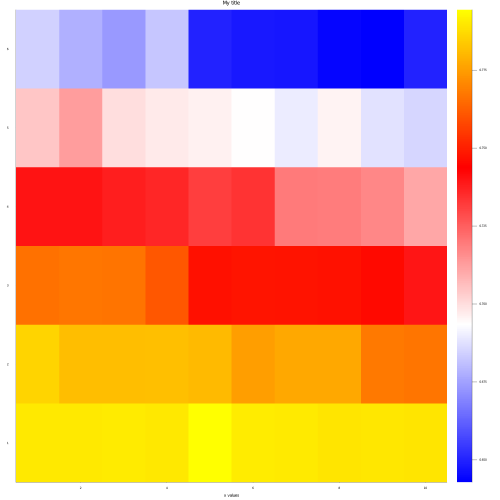

In [221]:
heatmap(1:size(state_ests_evals,1),
    1:size(state_ests_evals,2), state_ests_evals,
    c=cgrad([:blue, :white,:red, :yellow]),
    xlabel="x values", ylabel="y values",
    title="My title", size = (2000, 2000))

In [226]:
param_ests_evals

10×6 Matrix{Float64}:
 0.0159399  0.0145682  0.0138362  0.0151126  0.0229177  0.043329
 0.014664   0.0137371  0.0134048  0.0154479  0.024515   0.0461377
 0.0173401  0.0173092  0.0178504  0.0218103  0.0307618  0.0664146
 0.01485    0.0149321  0.0155516  0.0204475  0.0322827  0.0584924
 0.0209771  0.0205964  0.0208002  0.0248352  0.0366704  0.0581163
 0.0394823  0.0406613  0.0422452  0.0482758  0.0575445  0.070712
 0.0814134  0.0784929  0.0763234  0.0749615  0.0779912  0.0790576
 0.0929346  0.0884008  0.0851978  0.0819461  0.0821691  0.105035
 0.0561499  0.0593053  0.0625183  0.0711034  0.0828078  0.0875128
 0.0864801  0.0860742  0.0861271  0.0878322  0.094947   0.091707

In [227]:
state_ests_evals

10×6 Matrix{Float64}:
 0.79    0.79    0.7904  0.7898  0.7944  0.7906
 0.7902  0.7892  0.7896  0.7892  0.7858  0.7816
 0.7816  0.7818  0.7808  0.7752  0.7772  0.7772
 0.7678  0.767   0.7662  0.7672  0.7668  0.7612
 0.747   0.7478  0.7476  0.7472  0.7456  0.7398
 0.7402  0.7402  0.738   0.7364  0.7316  0.7338
 0.7196  0.7192  0.7172  0.7108  0.7046  0.7128
 0.6998  0.6974  0.6962  0.6936  0.6896  0.6958
 0.6876  0.6852  0.6842  0.6776  0.6732  0.682
 0.6496  0.6476  0.6472  0.6438  0.6428  0.6496

In [228]:
opt_param_ests_evals

10×6 Matrix{Float64}:
 0.0159399  0.0180416  0.0208934  0.0357867  0.0917626  1.41903
 0.014664   0.0163131  0.0186854  0.0306695  0.0706482  1.34999
 0.0173401  0.0181603  0.0199333  0.0315875  0.0854345  1.16786
 0.01485    0.0154369  0.0167311  0.0254053  0.0576098  1.23672
 0.0209771  0.021979   0.0236338  0.0333982  0.0707173  1.66063
 0.0394823  0.038968   0.0392163  0.0450225  0.0714801  1.25483
 0.0814134  0.0854003  0.0907884  0.114509   0.181998   1.48639
 0.0929346  0.0990716  0.106926   0.139207   0.212269   1.42412
 0.0561499  0.0533047  0.0509196  0.0470894  0.0721133  1.13435
 0.0864801  0.0870453  0.0875595  0.090351   0.111797   1.31238

In [229]:
opt_state_ests_evals

10×6 Matrix{Float64}:
 0.79    0.7898  0.7904  0.7898  0.7862  0.7406
 0.7902  0.788   0.7884  0.787   0.7848  0.7502
 0.7816  0.78    0.7812  0.7814  0.7808  0.7356
 0.7678  0.7664  0.7664  0.765   0.7636  0.736
 0.747   0.7472  0.7464  0.7438  0.7418  0.715
 0.7402  0.7426  0.7448  0.7412  0.7388  0.704
 0.7196  0.7182  0.7194  0.7224  0.7254  0.6988
 0.6998  0.7004  0.702   0.7042  0.7078  0.6684
 0.6876  0.6876  0.6886  0.6896  0.6884  0.659
 0.6496  0.6512  0.6512  0.656   0.6568  0.6264

In [232]:
best_acc = zeros(10) ; 

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [233]:
## To get baseline best accuracy

for i=1:10
    #print("A KL divergence for (noise, r) = ")
    print("Best state accuracy for noise = ")
    println(vars[i])
    k = eval_state_ests(X_noisy[i,:,:], S, pi_true, A_true, emission_dists)[2]
    println(tr(k)/sum(k))
    best_acc[i] = tr(k)/sum(k)
    #opt_state_ests_evals[i,j] = tr(k)/sum(k) ; 
end

Best state accuracy for noise = 0.1
0.7898
Best state accuracy for noise = 0.2
0.7892
Best state accuracy for noise = 0.30000000000000004
0.781
Best state accuracy for noise = 0.4
0.7712
Best state accuracy for noise = 0.5
0.748
Best state accuracy for noise = 0.6000000000000001
0.74
Best state accuracy for noise = 0.7000000000000001
0.7288
Best state accuracy for noise = 0.8
0.7034
Best state accuracy for noise = 0.9
0.6944
Best state accuracy for noise = 1.0
0.6672


In [234]:
best_acc

10-element Vector{Float64}:
 0.7898
 0.7892
 0.781
 0.7712
 0.748
 0.74
 0.7288
 0.7034
 0.6944
 0.6672

In [247]:
best_acc_test = zeros(10) ; 

In [248]:
## To get baseline best accuracy

for i=1:10
    #print("A KL divergence for (noise, r) = ")
    print("Best state accuracy for noise = ")
    println(vars[i])
    k = eval_state_ests(X_noisy_test[i,:,:], S_test, pi_true, A_true, emission_dists)[2]
    println(tr(k)/sum(k))
    best_acc_test[i] = tr(k)/sum(k)
    #opt_state_ests_evals[i,j] = tr(k)/sum(k) ; 
end

Best state accuracy for noise = 0.1
0.8292
Best state accuracy for noise = 0.2
0.8224
Best state accuracy for noise = 0.30000000000000004
0.8168
Best state accuracy for noise = 0.4
0.7936
Best state accuracy for noise = 0.5
0.7716
Best state accuracy for noise = 0.6000000000000001
0.7744
Best state accuracy for noise = 0.7000000000000001
0.758
Best state accuracy for noise = 0.8
0.75
Best state accuracy for noise = 0.9
0.696
Best state accuracy for noise = 1.0
0.6912


In [249]:
best_acc_test

10-element Vector{Float64}:
 0.8292
 0.8224
 0.8168
 0.7936
 0.7716
 0.7744
 0.758
 0.75
 0.696
 0.6912

In [194]:
eval_state_ests((X_noisy, S, pi_rob1, A_rob1, emission_dists[1:5]))

LoadError: MethodError: no method matching eval_state_ests(::Matrix{Float64}, ::Vector{Float64}, ::Matrix{Float64}, ::Vector{Float64})
[0mClosest candidates are:
[0m  eval_state_ests(::Any, ::Any, ::Any, ::Any, [91m::Any[39m) at In[36]:7

In [197]:
#X_noisy

In [173]:
vars

10-element Vector{Float64}:
 0.1
 0.2
 0.30000000000000004
 0.4
 0.5
 0.6000000000000001
 0.7000000000000001
 0.8
 0.9
 1.0

In [157]:
delta_X_initial

10×500 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [149]:
size(rs,1)

6

In [148]:
size(vars,1)

10

In [94]:
vars

10-element Vector{Float64}:
 0.2
 0.4
 0.6000000000000001
 0.8
 1.0
 1.2000000000000002
 1.4000000000000001
 1.6
 1.8
 2.0

In [74]:
A1

10×10 Matrix{Float64}:
 0.0829694   0.125076    0.0374064  …  0.0400239  0.108404   0.11555
 0.0664666   0.0351734   0.082449      0.159457   0.176632   0.0926286
 0.122447    0.0310558   0.0565831     0.0475749  0.0469444  0.108442
 0.00762164  0.127534    0.136699      0.138878   0.118476   0.0461156
 0.102447    0.110942    0.0780906     0.10526    0.15475    0.00962583
 0.0314577   0.124655    0.129818   …  0.105665   0.112492   0.0202601
 0.0955016   0.0876148   0.156077      0.0279359  0.145021   0.0402199
 0.168579    0.00800755  0.113444      0.160669   0.0563856  0.0523764
 0.148479    0.00795998  0.162788      0.0535303  0.0726333  0.187784
 0.117551    0.114637    0.0727653     0.0913067  0.13747    0.147456

In [75]:
A_true

10×10 Matrix{Float64}:
 0.0752931   0.1341      0.0197698  …  0.0199917  0.116939   0.131136
 0.0850281   0.00812193  0.110777      0.140611   0.160813   0.102774
 0.118604    0.0305247   0.0441062     0.0406136  0.0577275  0.11217
 0.00860176  0.133947    0.124884      0.13774    0.108742   0.0446017
 0.114674    0.100397    0.0918971     0.131533   0.127359   0.0111749
 0.03043     0.148723    0.100613   …  0.0977629  0.14696    0.0136002
 0.0678053   0.0963498   0.161962      0.0260425  0.137581   0.0375044
 0.184826    0.00294772  0.125397      0.194892   0.0573867  0.0430482
 0.135083    0.00606615  0.176531      0.0378103  0.0582549  0.194518
 0.105152    0.0999984   0.0828344     0.0766694  0.173632   0.148507

In [77]:
A2

10×10 Matrix{Float64}:
 0.0887195  0.100965   0.0577848  …  0.0595478  0.102915   0.120092
 0.0758773  0.0472307  0.0694771     0.135044   0.144917   0.10327
 0.100104   0.0469516  0.0751991     0.0755182  0.0622329  0.100753
 0.0374936  0.106118   0.128988      0.123517   0.109938   0.0589358
 0.0940789  0.0994974  0.0991351     0.111933   0.130511   0.0235105
 0.0524033  0.107267   0.126618   …  0.104305   0.107617   0.0294114
 0.104635   0.0900601  0.139976      0.0605155  0.113155   0.0491084
 0.148837   0.0358749  0.129247      0.130246   0.0676679  0.0739
 0.135124   0.0329733  0.139342      0.0607424  0.0835687  0.165651
 0.127547   0.0964253  0.0791961     0.0876115  0.120949   0.149143

In [71]:
rs

10-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.30000000000000004
 0.4
 0.5
 0.6000000000000001
 0.7000000000000001
 0.8
 0.9

In [64]:
num_iters

40

0.4

In [46]:
emission_dists[1]

Normal{Float64}(μ=0.0, σ=1.0)

In [50]:
rand(Normal(0,var[1]) , size(X))  

20×1000 Matrix{Float64}:
 -0.0221935   -0.548499   0.793209   …  -0.619684    0.71986   -0.207491
  1.65099     -0.400339   2.13998        0.0314424  -1.22888    0.428426
 -0.231567    -0.167208  -0.418241       0.147931   -0.419959   1.44388
  0.849515     0.486502   0.600834      -0.976467   -0.337392   2.8517
 -0.925499     0.863419  -1.02804        0.439497    1.23832   -0.819009
  0.528921    -0.895293  -0.100872   …   0.82283     0.449653   0.351318
 -0.00393545  -0.173272   2.58189       -0.78087     0.206083   0.457902
 -0.0345837    0.226868  -0.301432      -0.442338    1.60951    0.661481
  0.450154     0.990216   0.309564      -0.448063    0.295202  -0.484748
  1.35256     -0.379159   1.1453        -0.714318    0.237985  -0.916938
 -0.582046     1.50661    0.787297   …  -0.169835   -0.771688  -0.494973
  0.318703     2.24823    0.243438       1.30322     1.43461    0.130618
 -0.506908     0.662333  -0.794548      -1.64552     0.256457  -2.06454
  1.70581     -1.49213   -1.96

In [93]:
tr(conf_mat_best)

3874.0

In [94]:
tr(conf_mat_em)

3822.0

In [95]:
tr(conf_mat_rob1)

3825.0

In [96]:
tr(conf_mat_rob2)

3855.0

In [97]:
tr(conf_mat_rob3)

3870.0

In [81]:
tr(conf_mat_em)/sum(conf_mat_em)

0.7754

In [77]:
emission_dists[1:5]

5-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=0.0, σ=1.0)
 Normal{Float64}(μ=2.0, σ=1.0)
 Normal{Float64}(μ=4.0, σ=1.0)
 Normal{Float64}(μ=6.0, σ=1.0)
 Normal{Float64}(μ=8.0, σ=1.0)

In [66]:
println(eval_param_ests(A_true, pi_true, A_em, pi_em)) ; 

(5.248430558516643, 0.5822538512665225, 0.015141032754393388, 0.01511053453507279)


In [60]:
kldivergence(pi_true, pi_em)

5.248430558516643

In [58]:
A_true

5×5 Matrix{Float64}:
 0.297786   0.135445   0.360448  0.132384  0.0739377
 0.0569891  0.0932441  0.40251   0.118168  0.329089
 0.139272   0.279702   0.197464  0.184547  0.199014
 0.216932   0.21829    0.19214   0.244652  0.127986
 0.184545   0.0563216  0.264807  0.234137  0.260189

In [59]:
A_em

5×5 Matrix{Float64}:
 0.304047   0.0985392  0.352008  0.157189   0.0882165
 0.0411539  0.114897   0.42822   0.0930912  0.322638
 0.114125   0.302731   0.143974  0.273843   0.165326
 0.269708   0.208153   0.217632  0.185234   0.119273
 0.200815   0.0406265  0.249331  0.206193   0.303034

5-element Vector{Float64}:
 2.1934043809720405e-7
 0.686402512031133
 0.20083651520834045
 0.012233084939112968
 0.1005276684809755

In [33]:
sum(h[5,:])

1.0

In [41]:
A_rob2 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.01_noise-0.1_A.csv", DataFrame))) ; 
pi_rob2 = Matrix(DataFrame(CSV.read("Saved_Params/r-0.01_noise-0.1_pi.csv", DataFrame))) ; 



### Things to start putting in report 

1. Introduction - Set up EM algorithm idea, write up first principles math what kind of estimation it tries to do
    2. General Idea of project: Show which part of EM algorithm overall we are trying to modify, show part where we add robustness
    
2. Context: EM algorithm in the context of Hidden Markov models. Baum-Welch algorithm. What kidn of things it is used to model etc.

3. Write-up EM algorithm for HMM all the different terms to be computed, forward-backward algorithm etc -- Do not work out -- Use existing literature - Show math for multiple sequences

4. Add robustness to single dimensional Gaussian case - Simplify the equation and show what kind of optimization problem it boils down to

----------------------------------------------

5. Experiments
    1. Data description - 
    2. Different algorithms we are testing, what we are comparing etc etc etc 
    3. Performance for different noise levels, different levels of robustness, optimistic algorithm
    4. Performance on test data